<a href="https://colab.research.google.com/github/IldarAltynbaev/MLSnippetSimpleNeuroNwtwork/blob/TestingColab/StepikRanForContest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd
import numpy as np
from google.colab import drive
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

drive.mount('/content/drive')

#Функции для рассчета агрегаты нужных полей
def count_correct(series):
    return (series == 'correct').sum()
def count_wrong(series):
    return (series == 'wrong').sum()
def count_viewed(series):
    return (series == 'viewed').sum()
def count_passed(series):
    return (series == 'passed').sum()
def count_discovered(series):
    return (series == 'discovered').sum()
def count_started_attempt(series):
    return (series == 'started_attempt').sum()

def get_correct_wrong_table (submission_initial, time_delta=None):

    if time_delta is not None:
        submission_initial['date_time'] = pd.to_datetime(submission_initial.timestamp, unit='s')
        submission_first_date = submission_initial.groupby(['user_id'])['date_time'].min().reset_index(name='first_date')
        submission_initial = submission_initial.merge(submission_first_date, on='user_id', how='left')
        submission_initial = submission_initial[submission_initial.date_time <= submission_initial.first_date + timedelta(days=time_delta)]
        submission_initial = submission_initial.drop(['date_time','first_date'],axis=1)

    submission_initial = submission_initial.drop(['timestamp'],axis=1)

    submission_initial_wrong_not_unique = submission_initial.copy()

    submission_initial = submission_initial.drop_duplicates()

    submission_initial_wrong_not_unique = submission_initial_wrong_not_unique.pivot_table(values='step_id',
                                                                                          columns='submission_status',
                                                                                          index='user_id',
                                                                                          aggfunc='count'). \
                                                                                          fillna(0).reset_index()
    submission_initial_wrong_not_unique = submission_initial_wrong_not_unique.drop(['correct'],axis=1)

    submission_initial = submission_initial.pivot_table(values='step_id', columns='submission_status',index='user_id', \
                                                        aggfunc=pd.Series.nunique).fillna(0).reset_index()
    submission_initial = submission_initial.drop(['wrong'], axis=1)
    submission_initial = submission_initial.merge(submission_initial_wrong_not_unique, on='user_id',how='left').fillna(0)

    return submission_initial

def get_events_first2Days (events_initial,submission_initial):
    events_initial['date_time'] = pd.to_datetime(events_initial.timestamp,unit='s')

    first_2_Days = events_initial.groupby(['user_id'])['date_time'].min().reset_index(name='first_date')

    events_initial = events_initial.merge(first_2_Days, on='user_id', how='left')
    events_initial = events_initial[events_initial.date_time <= events_initial.first_date + timedelta(days=2)]
    events_initial = events_initial.drop(['timestamp', 'date_time', 'first_date'],axis=1)
    events_initial = events_initial.pivot_table(values='step_id', index='user_id', columns='action',aggfunc='count').fillna(0)

    pass_not_pass_table = get_correct_wrong_table(submission_initial)

    events_initial = events_initial.merge(pass_not_pass_table, on='user_id', how='left').fillna(0)
    events_initial['passed_course'] = events_initial.correct > 40
    events_initial = events_initial.drop(['correct', 'wrong'],axis=1)
    submits_first2Days = get_correct_wrong_table(submission_initial, time_delta=2)
    events_initial = events_initial.merge(submits_first2Days, on='user_id', how='left').fillna(0)

    return events_initial

def get_test_data(events_initial, submission_initial):
    submission_table = get_correct_wrong_table(submission_initial)
    events_initial = events_initial.drop(['timestamp'],axis=1)
    events_initial = events_initial.pivot_table(values='step_id', index='user_id', columns='action',aggfunc='count').fillna(0)
    result_table = pd.merge(events_initial, submission_table, how='left', on='user_id').fillna(0)

    return result_table

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
events_initial = pd.read_csv('/content/drive/MyDrive/DS data/events_data_train.csv')
submission_initial = pd.read_csv('/content/drive/MyDrive/DS data/submissions_data_train.csv')
user_data = get_events_first2Days(events_initial, submission_initial)
user_data = user_data.set_index('user_id')


set_x = user_data.drop(['passed_course'],axis=1)
set_y =pd.DataFrame(user_data['passed_course'])
#set_x.to_csv('/content/drive/MyDrive/DS data/x.csv')
#set_y.to_csv('/content/drive/MyDrive/DS data/y.csv')
X_train, X_test, y_train, y_test = train_test_split(set_x, set_y, train_size = 0.8)
clf = RandomForestClassifier(criterion='entropy')

param_grid = {'n_estimators':range(1,60,10), 'max_depth':range(1,50,10),'min_samples_leaf': range(1,50,10),'min_samples_split': range(1,50,10)}
grid = GridSearchCV(clf,param_grid,cv=5)


In [ ]:
grid.fit(X_train,y_train.values.ravel())
tree_cls = grid.best_estimator_
print(grid.best_params_)
grid.best_score_

In [29]:
y_pred = tree_cls.predict_proba(X_test)
metrics.roc_auc_score(y_test, y_pred[:,1])

0.8834163765593269

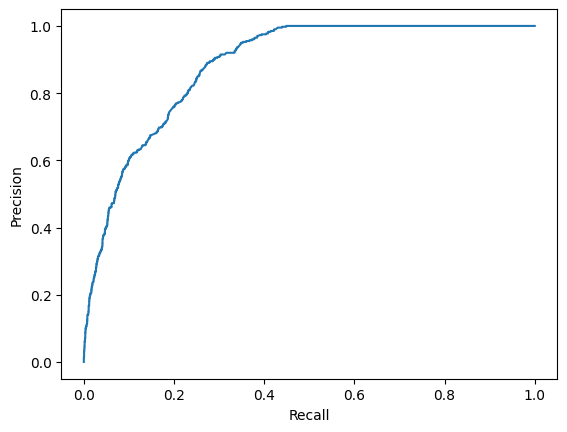

In [30]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred[:,1])
plt.plot(fpr,tpr)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [46]:
events_initial = pd.read_csv('/content/drive/MyDrive/DS data/events_data_test.csv')
submission_initial = pd.read_csv('/content/drive/MyDrive/DS data/submissions_data_test.csv')
user_data = get_test_data(events_initial, submission_initial)
user_data = user_data.set_index('user_id')
y_pred = tree_cls.predict_proba(user_data)
user_data['prediction'] = y_pred[:,1]
user_data = user_data.drop(['discovered','passed','started_attempt','discovered','correct','viewed','wrong'],axis=1)
user_data.to_csv('/content/drive/MyDrive/DS data/res_alt.csv')